In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from pandas.plotting import parallel_coordinates
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates

palette = sns.color_palette("bright", 10)
 
df = pd.read_csv('gdrive/My Drive/proyectointegrador/FINALDatosLimpios.csv')
df3 = pd.read_csv('gdrive/My Drive/proyectointegrador/FINALDatosLimpiosBINARIOS.csv')

In [ ]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-50, 50], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-50, 50], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

In [ ]:
def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)  

In [ ]:
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)  

In [ ]:
def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

In [ ]:
df.shape

(3027853, 37)

In [ ]:
df.head()

,Unnamed: 0,Amenity,Astronomical_Twilight,Bump,City,Civil_Twilight,County,Crossing,Give_Way,Hour,Junction,Nautical_Twilight,No_Exit,Railway,Roundabout,Severity,Start_Lat,Start_Lng,State,Station,Stop,Street,Sunrise_Sunset,Traffic_Calming,Traffic_Signal,Turning_Loop,Weather_Condition,Wind_Direction,dayOfWeek,month,newSeverity,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Description
0,0,0,0,0,11194,1,317,0,0,6,0,0,0,0,0,2,39.063148,-84.032608,33,0,0,142196,1,0,1,0,77,15,0,2,2,-1.413528,1.584296,-0.040193,0.298707,-0.899846,Accident on OH-32 State Route 32 Westbound at ...
1,1,0,0,0,2467,0,1037,0,0,7,0,0,0,0,0,3,39.747753,-84.205582,33,0,0,84982,1,0,0,0,74,15,0,2,2,-1.461671,1.407576,-0.074852,-0.056635,-0.690152,Accident on I-75 Southbound at Exits 52 52B US...
2,2,0,0,0,2467,0,1037,0,0,7,0,0,0,0,0,2,39.627781,-84.188354,33,0,0,99315,0,0,1,0,74,15,0,2,2,-1.413528,1.098315,-0.063299,-1.122663,-0.899846,Accident on McEwen Rd at OH-725 Miamisburg Cen...
3,3,0,0,0,11058,0,545,0,0,7,0,0,0,0,0,3,40.100590,-82.925194,33,0,0,159416,0,0,0,0,54,14,0,2,2,-1.311892,1.451756,-0.086405,-0.767321,-0.899846,Accident on I-270 Outerbelt Northbound near Ex...
4,4,0,0,0,2467,0,1037,0,0,7,0,0,0,0,0,2,39.758274,-84.230507,33,0,0,108335,0,0,0,0,77,21,0,2,2,-1.520513,1.584296,-0.051746,-0.767321,-0.899846,Accident on Oakridge Dr at Woodward Ave. Expec...


In [ ]:
print(df.groupby('Severity').size())

Severity
1      28406
2    2058303
3     846903
4      94241
dtype: int64


In [ ]:
print(df.groupby('newSeverity').size())

newSeverity
1     361690
2    1006664
3     494148
4    1165351
dtype: int64


In [ ]:
dropColumns = ['month','dayOfWeek','Hour','Severity','newSeverity','Start_Lat','Start_Lng','Description','Street','City','County','State','Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Unnamed: 0']

In [ ]:
df2 = df.drop(dropColumns, axis=1)

In [ ]:
df2.head()

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph)
0,-1.413528,1.584296,-0.040193,0.298707,-0.899846
1,-1.461671,1.407576,-0.074852,-0.056635,-0.690152
2,-1.413528,1.098315,-0.063299,-1.122663,-0.899846
3,-1.311892,1.451756,-0.086405,-0.767321,-0.899846
4,-1.520513,1.584296,-0.051746,-0.767321,-0.899846


In [ ]:
X = np.array(df2)
X.shape

(3027853, 5)

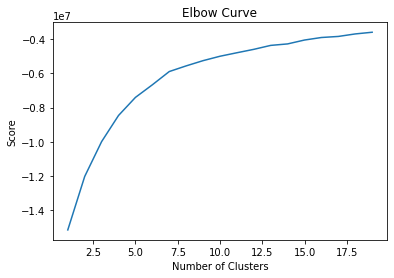

In [ ]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# K-Means con 4 clusters

In [ ]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.30460425 -0.69935081 -4.9121658   0.25243453 -0.02713461]
 [-0.43023915  0.48584619  0.19724447  0.2200289  -0.26041706]
 [ 0.68793998 -0.82614966  0.1092461   0.31134595  0.29181718]
 [-0.66179309  1.1884237   0.05858663 -2.0660697   0.00672749]]


**Temperatura, Humedad y Visibilidad**

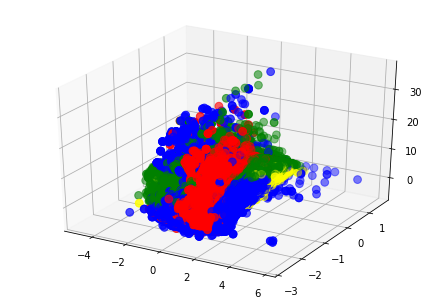

In [ ]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 3], c=asignar,s=60) #Temperatura, Humedad, Visibilidad
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

**Humedad, Visibilidad y Velocidad del viento**

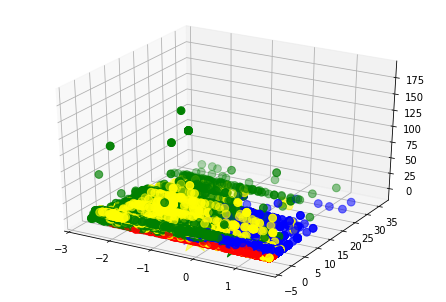

In [ ]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 1], X[:, 3], X[:, 4], c=asignar,s=60) #Humedad, Visibilidad, Velocidad del viento
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

**Temperatura, Humedad, Presión**

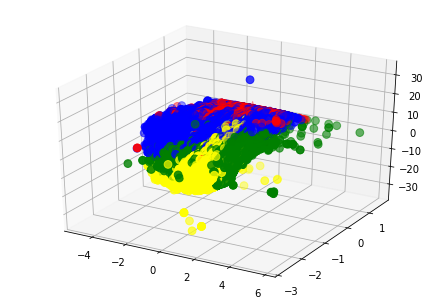

In [ ]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60) #Temperatura, Humedad, Presión
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [ ]:
copy =  pd.DataFrame()
copy['Unnamed: 0']=df['Unnamed: 0'].values
copy['Severity']=df['Severity'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,342357
1,green,1224674
2,blue,1374328
3,yellow,86494


**Severidad cluster rojo**

In [ ]:
group_referrer_index = copy['label'] ==0
group_referrals = copy[group_referrer_index]
 
diversidadGrupo =  pd.DataFrame()
diversidadGrupo['Severity']=[0,1,2,3,4]
diversidadGrupo['cantidad']=group_referrals.groupby('Severity').size()
diversidadGrupo

,Severity,cantidad
0,0,NaN
1,1,19387.0
2,2,1027251.0
3,3,419858.0
4,4,42711.0


**Severidad cluster verde**

In [ ]:
group_referrer_index = copy['label'] ==1
group_referrals = copy[group_referrer_index]
 
diversidadGrupo =  pd.DataFrame()
diversidadGrupo['Severity']=[0,1,2,3,4]
diversidadGrupo['cantidad']=group_referrals.groupby('Severity').size()
diversidadGrupo

,Severity,cantidad
0,0,NaN
1,1,9019.0
2,2,1031052.0
3,3,427045.0
4,4,51530.0


**Severidad cluster azul**

In [ ]:
group_referrer_index = copy['label'] ==2
group_referrals = copy[group_referrer_index]
 
diversidadGrupo =  pd.DataFrame()
diversidadGrupo['Severity']=[0,1,2,3,4]
diversidadGrupo['cantidad']=group_referrals.groupby('Severity').size()
diversidadGrupo

,Severity,cantidad
0,0,NaN
1,1,8468.0
2,2,937461.0
3,3,382124.0
4,4,46275.0


**Severidad cluster amarillo**

In [ ]:
group_referrer_index = copy['label'] ==3
group_referrals = copy[group_referrer_index]
 
diversidadGrupo =  pd.DataFrame()
diversidadGrupo['Severity']=[0,1,2,3,4]
diversidadGrupo['cantidad']=group_referrals.groupby('Severity').size()
diversidadGrupo

,Severity,cantidad
0,0,NaN
1,1,4767.0
2,2,60515.0
3,3,18053.0
4,4,3159.0


# Variables vs Cluster

**Variables**

- Temperature(F)
- Humidity(%)
- Pressure(in)
- Visibility(mi)
- Wind_Speed(mph)

**Temperatura y Humedad**

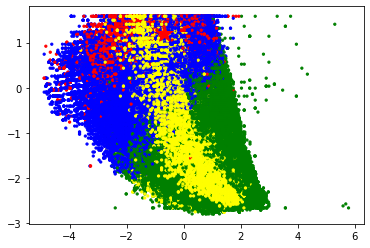

In [ ]:
# Getting the values and plotting it
f1 = df2['Temperature(F)'].values
f2 = df2['Humidity(%)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

**Temperatura y Presión**

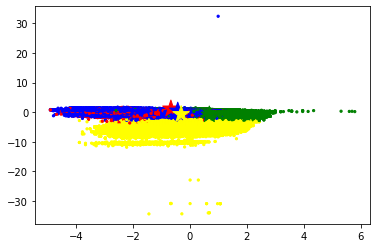

In [ ]:
# Getting the values and plotting it
f1 = df2['Temperature(F)'].values
f2 = df2['Pressure(in)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

**Temperatura y Visibilidad**

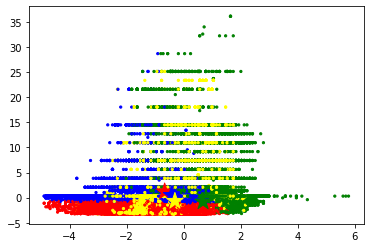

In [ ]:
# Getting the values and plotting it
f1 = df2['Temperature(F)'].values
f2 = df2['Visibility(mi)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

**Temperatura y Velocidad del viento**

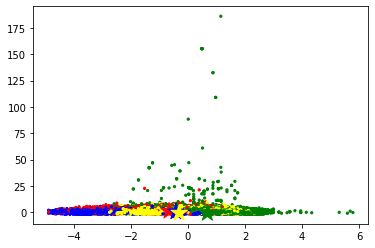

In [ ]:
# Getting the values and plotting it
f1 = df2['Temperature(F)'].values
f2 = df2['Wind_Speed(mph)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

# Variables en las que los clusters se comportan de forma similar

- Velocidad del viento(*)



# Variables en las que los clusters se comportan de forma distinta

- Temperatura
- Humedad
- Presión
- Visibilidad

# Proyección de las 5 variables numéricas en 2 dimensiones - PCA

In [ ]:
# Add cluster number to the original data
X_clustered = pd.DataFrame(X, columns=df2.columns, index=df2.index)
X_clustered['cluster'] = labels

X_clustered.head()

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),cluster
0,-1.413528,1.584296,-0.040193,0.298707,-0.899846,2
1,-1.461671,1.407576,-0.074852,-0.056635,-0.690152,2
2,-1.413528,1.098315,-0.063299,-1.122663,-0.899846,0
3,-1.311892,1.451756,-0.086405,-0.767321,-0.899846,0
4,-1.520513,1.584296,-0.051746,-0.767321,-0.899846,0


In [ ]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(X)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(X)

In [ ]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=df2.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = labels
X_reduceddf.head()

,PC1,PC2,cluster
0,-1.702811,-0.515996,2
1,-1.769909,-0.236356,2
2,-2.160023,-0.220870,0
3,-2.141106,-0.333563,0
4,-2.335093,-0.300146,0


In [ ]:
centres_reduced = pca.transform(kmeans.cluster_centers_)

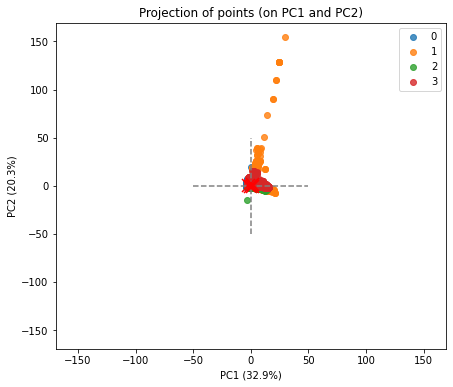

In [ ]:
display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = labels, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

# Distribución de las variables por centroide

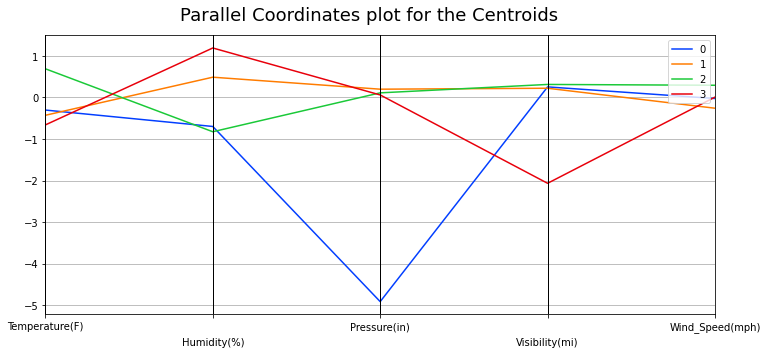

In [ ]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df2.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 5)

# K-Means con 2 clusters

In [ ]:
kmeans = KMeans(n_clusters=2).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 0.56918702 -0.74496549 -0.06484878  0.32741339  0.21581962]
 [-0.56579577  0.74052695  0.06446241 -0.32546264 -0.21453375]]


**Temperatura, Humedad y Visibilidad**

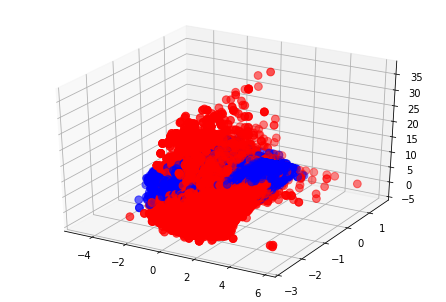

In [ ]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 3], c=asignar,s=60) #Temperatura, Humedad, Visibilidad
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

**Humedad, Visibiliad y Velocidad del viento**

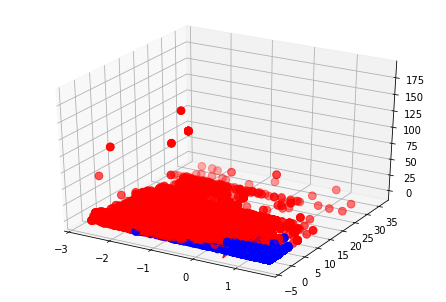

In [ ]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 1], X[:, 3], X[:, 4], c=asignar,s=60) #Humedad, Visibilidad, Velocidad del viento
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

**Temperatura, Humedad y Presión**

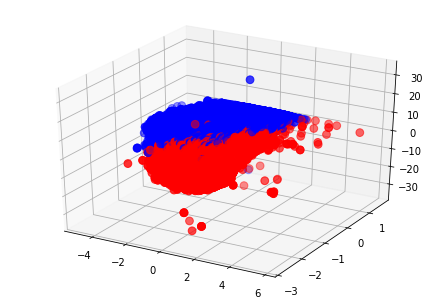

In [ ]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60) #Temperatura, Humedad, Presión
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [ ]:
copy =  pd.DataFrame()
copy['Unnamed: 0']=df3['Unnamed: 0'].values
copy['Severity']=df3['Severity'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,1509207
1,blue,1518646


**Severidad cluster rojo**

In [ ]:
group_referrer_index = copy['label'] ==0
group_referrals = copy[group_referrer_index]
 
diversidadGrupo =  pd.DataFrame()
diversidadGrupo['Severity']=[0,1]
diversidadGrupo['cantidad']=group_referrals.groupby('Severity').size()
diversidadGrupo

,Severity,cantidad
0,0,1046638
1,1,462569


**Severidad cluster azul**

In [ ]:
group_referrer_index = copy['label'] ==1
group_referrals = copy[group_referrer_index]
 
diversidadGrupo =  pd.DataFrame()
diversidadGrupo['Severity']=[0,1]
diversidadGrupo['cantidad']=group_referrals.groupby('Severity').size()
diversidadGrupo

,Severity,cantidad
0,0,1040071
1,1,478575


# Variables vs Cluster

**Variables**

- Temperature(F)
- Humidity(%)
- Pressure(in)
- Visibility(mi)
- Wind_Speed(mph)

**Temperatura y Humedad**

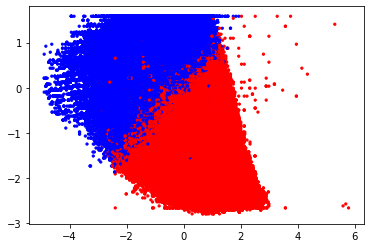

In [ ]:
# Getting the values and plotting it
f1 = df3['Temperature(F)'].values
f2 = df3['Humidity(%)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

**Temperatura y Presión**

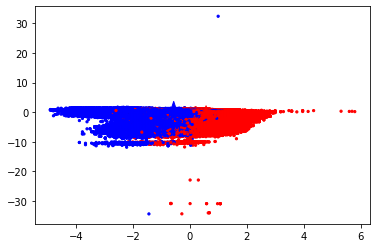

In [ ]:
# Getting the values and plotting it
f1 = df3['Temperature(F)'].values
f2 = df3['Pressure(in)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

**Temperatura y Visibilidad**

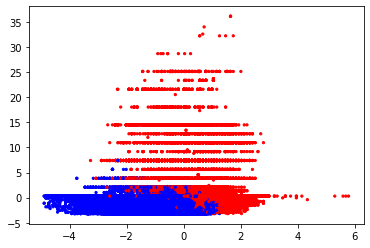

In [ ]:
# Getting the values and plotting it
f1 = df3['Temperature(F)'].values
f2 = df3['Visibility(mi)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

**Temperatura y Visibilidad del viento**

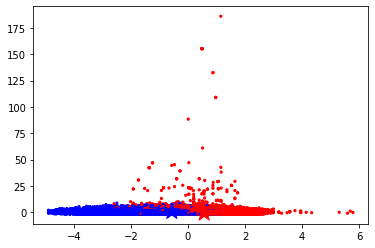

In [ ]:
# Getting the values and plotting it
f1 = df2['Temperature(F)'].values
f2 = df2['Wind_Speed(mph)'].values

plt.scatter(f1, f2, c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=300)
plt.show()

# Variables en las que los clsuters se comportan de forma similar

- Presión

# Variables en las que los clusters se comportan de forma distinta

- Temperatura
- Humedad
- Presión
- Visibilidad
- Velocidad del viento

# Proyección de las 5 variables numéricas en 2 dimensiones - PCA

In [ ]:
# Add cluster number to the original data
X_clustered = pd.DataFrame(X, columns=df2.columns, index=df2.index)
X_clustered['cluster'] = labels

X_clustered.head()

,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),cluster
0,-1.413528,1.584296,-0.040193,0.298707,-0.899846,1
1,-1.461671,1.407576,-0.074852,-0.056635,-0.690152,1
2,-1.413528,1.098315,-0.063299,-1.122663,-0.899846,1
3,-1.311892,1.451756,-0.086405,-0.767321,-0.899846,1
4,-1.520513,1.584296,-0.051746,-0.767321,-0.899846,1


In [ ]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(X)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(X)

In [ ]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=df2.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = labels
X_reduceddf.head()

,PC1,PC2,cluster
0,-1.702811,-0.515996,1
1,-1.769909,-0.236356,1
2,-2.160023,-0.220870,1
3,-2.141106,-0.333563,1
4,-2.335093,-0.300146,1


In [ ]:
centres_reduced = pca.transform(kmeans.cluster_centers_)

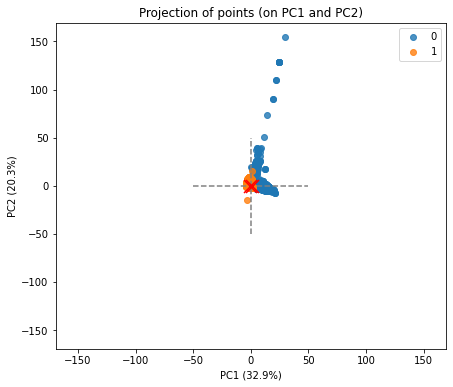

In [ ]:
display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = labels, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

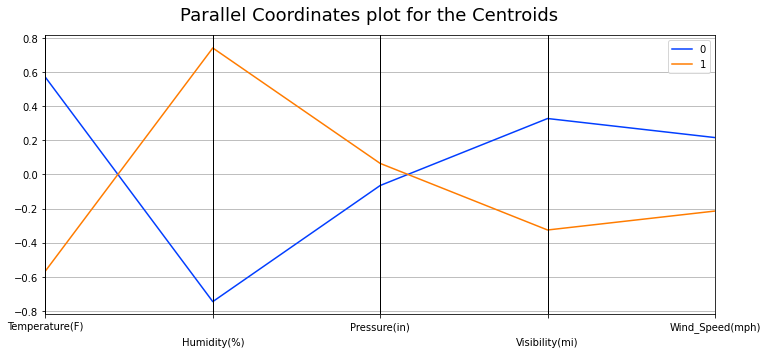

In [ ]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df2.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 5)